# Clean-Label Feature Collision Attacks on a Keras Classifier

In this notebook, we will learn how to use ART to run a clean-label feature collision poisoning attack on a neural network. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/1804.00792) by Shafahi, Huang, et. al. 2018.

In [1]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Load Model to be Attacked

In this example, we using a RESNET50 model pretrained on the CIFAR dataset.

In [3]:
path = get_file('cifar_alexnet.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_alexnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Choose Target Image from Test Set

true_class: bird
predicted_class: bird


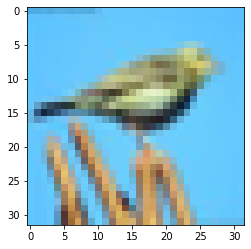

In [4]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)

fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])
# target_instance = x_test[]

feature_layer = classifier.layer_names[-2]

## Poison Training Images to Misclassify Test

The attacker wants to make it such that whenever a prediction is made on this particular cat the output will be a horse.

In [5]:
base_class = "frog" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]

x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


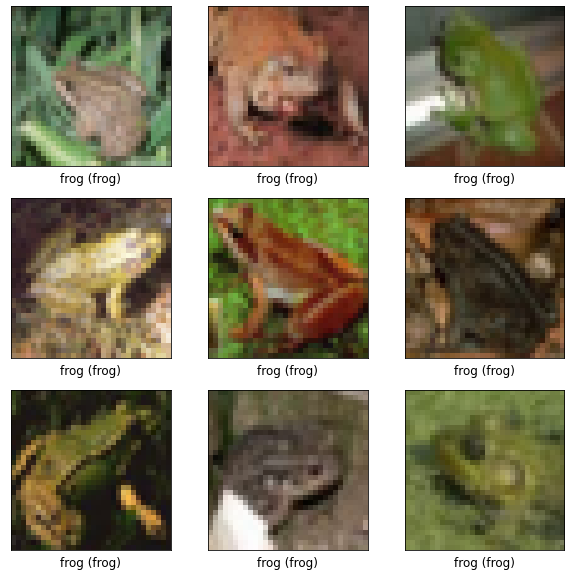

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

The captions on the images can be read: `predicted label (true label)`

## Creating Poison Frogs

In [7]:
attack = FeatureCollisionAttack(classifier, target_instance, feature_layer, max_iter=10)
poison = attack.poison(base_instances)

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


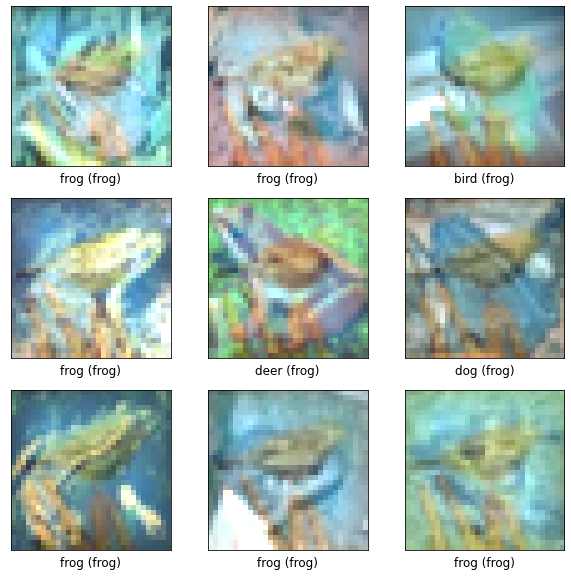

In [8]:
# print(base_instances.shape)
# print(poison.shape)
# # watermarking trick
# poison = np.clip(poison + 0.35 * target_instance, 0, 1) #0.4 worked
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

## Training with Poison Images
Note that the predicted label usually stays the same

In [9]:
model_layers = classifier._model.layers
i = 0
set_trainable = False
# for layer in model_layers:
#     if layer.name == feature_layer:
#         set_trainable = True
#     layer.trainable = set_trainable

# for layer in model_layers:
#     layer.trainable = True

classifier.set_learning_phase(True)
# print(classifier._layer_names[-4])
# print(classifier._model.layers[-5].trainable)
print(x_train.shape)
print(base_instances.shape)
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, base_labels])
classifier.fit(adv_train, adv_labels, nb_epochs=5, batch_size=4)
# classifier.fit(poison, base_labels, nb_epochs=10, batch_size=1)

(1000, 32, 32, 3)
(10, 32, 32, 3)
Epoch 1/5
252/252 [==============================] - 18s 72ms/step - loss: 0.4020 - accuracy: 0.9177
Epoch 2/5
252/252 [==============================] - 16s 63ms/step - loss: 0.3967 - accuracy: 0.9256
Epoch 3/5
252/252 [==============================] - 16s 63ms/step - loss: 0.2288 - accuracy: 0.9563
Epoch 4/5
252/252 [==============================] - 16s 65ms/step - loss: 0.1711 - accuracy: 0.9752
Epoch 5/5
252/252 [==============================] - 16s 64ms/step - loss: 0.1399 - accuracy: 0.9841


## Fooled Network Misclassifies Bird

true_class: bird
predicted_class: frog


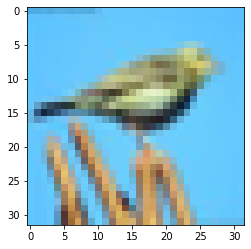

In [10]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

## A One-Shot Attack

In [11]:
### ## plot images diffs #imperceptible
# poison_pred = np.argmax(classifier.predict(poison), axis=1)
# plt.figure(figsize=(10,10))
# for i in range(0, 9):
#     pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(y_train[i])]
#     plt.subplot(330 + 1 + i)
#     print('max_diff: ' + str(np.max(np.abs(poison[i] - x_train[i]))))
#     fig=plt.imshow(np.abs(poison[i] - x_train[i]))
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
#                   horizontalalignment='center')

poison.shape

(10, 32, 32, 3)

In [12]:
poison = base_images
print(base_images.shape)
print('num base images: ' + str(len(base_images)))
target_feature_rep = classifier.get_activations(target, feature_layer, 1, intermediate=True)
poison_feature_rep = classifier.get_activations(poison, feature_layer, 1, intermediate=True)
print('feature rep type: ' + str(poison_feature_rep))

attack_loss = classifier.normalize_tensor(poison_feature_rep - target_feature_rep)
print('attack_loss input shape: ' +  str(attack_loss))

print('attack loss type: ' + str(type(attack_loss)))
attack_grad = classifier.custom_gradient(attack_loss, classifier.get_input_layer(), poison)

NameError: name 'base_images' is not defined

In [ ]:
target_instances = x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)]
base_examples = x_test[np.argmax(y_test, axis=1) == class_descr.index(base_class)]
target_activations = classifier.get_activations(target_instances, feature_layer, 100)
base_activations = classifier.get_activations(base_examples, feature_layer, 128)
poison_activations = classifier.get_activations(poison, feature_layer, 128)
print(target_activations.shape)
print(base_activations.shape)
print(poison_activations.shape)

In [ ]:
from art.utils import reduce_dimensionality
target_activations_2d = reduce_dimensionality(target_activations, nb_dims=2)
base_activations_2d = reduce_dimensionality(base_activations, nb_dims=2)
poison_activations_2d = reduce_dimensionality(poison_activations, nb_dims=2)
print(target_activations_2d.shape)
print(base_activations_2d.shape)
print(poison_activations_2d.shape)

In [ ]:
## TODO: some visualizations

In [ ]:
model_layers = classifier.layer_names
print(model_layers)